In [1]:
import sys
sys.path.append("..") 

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
from os.path import exists
import xarray as xr

import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from statsmodels.tsa.seasonal import STL


import geopandas as gdp
from scipy import sparse
from scipy.linalg import solve
from scipy.sparse.linalg import spsolve

from libpysal.weights import Queen, KNN, fuzzy_contiguity, w_union, W
from esda.moran import Moran
import networkx as nx
import warnings
from itertools import zip_longest

config = {
    'figure.figsize':(14,4),
    'figure.constrained_layout.use':True,
    'figure.facecolor':'w',
    'axes.grid':False,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

In [2]:
from laos_gggi import load_all_data, load_gpcc_data, load_emdat_data, load_shapefile
from laos_gggi.replication_data import create_replication_data
from laos_gggi.const_vars import COUNTRIES_ISO, ISO_DICTIONARY

# Data loading and preparation

In [3]:
df = create_replication_data()

C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\notebooks\..\laos_gggi\data_functions\emdat_processing.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_raw["disaster_class"].loc[
C:\Users\camil\Documents\Servicios\OCDE

In [4]:
#Load shapefiles
world = load_shapefile('world', repair_ISO_codes=True)
laos = load_shapefile('laos')

## Dropping years without damages
We model the expected damages conditional to the occurrence of disasters, therefore we exclude the years without disasters

In [5]:
df_climatological = df.query('Total_Damage_Adjusted_clim > 0')
df_hydrometereological = df.query('Total_Damage_Adjusted_hydro > 0')

## Reconcile EMDAT and shapefile ISO codes

In [6]:
#Load shapefiles
world = load_shapefile('world', repair_ISO_codes=True)
world.set_index('ISO_A3', inplace=True)

In [7]:
df_iso = df_hydrometereological["ISO"].unique()
world_iso = world.index.unique()

In [8]:
# Codes in EMDAT but not in world
# These are all historical:
", ".join(list(set(df_iso) - set(world_iso)))

''

In [9]:
# Codes in shapefile but not in EMDAT
", ".join(list(set(world_iso) - set(df_iso)))

'ISR, QAT, MHL, COM, GUM, MNE, SLE, IMN, JOR, LUX, SLB, CUW, GIN, BMU, SPM, WLF, VCT, PRK, SYC, HKG, UNK, LVA, VAT, GAB, FRO, COK, GRL, MNP, LSO, TGO, SUR, PSE, BTN, MCO, CYP, SSD, SXM, TUV, KNA, GIB, FIN, FSM, GMB, ATF, UZB, CPV, KIR, DMA, VIR, SYR, KWT, NCL, SHN, MLI, PCN, NIU, GRD, GNQ, TKM, SGP, DNK, GNB, AND, BRB, SGS, BEL, HMD, LIE, MDV, CIV, IOT, ABW, CYM, LCA, MSR, TCA, FLK, TON, JEY, ASM, BHR, TTO, ISL, SMR, STP, MAC, VEN, PRI, BLM, AIA, EST, LBR, JAM, BRN, SWE, MAF, NRU, NFK, GGY, BHS, ATG, DJI, VGB, MLT, PLW, ARE'

In [10]:
# Drop codes not in both
common_codes = set(world_iso).intersection(set(df_iso))
df_hydrometereological = df_hydrometereological.set_index(["ISO", "year"]).loc[lambda x: x.index.get_level_values(0).isin(common_codes)].copy()

world = world.loc[world.index.isin(common_codes)].copy()

df_hydrometereological = df_hydrometereological.reset_index()

In [11]:
# Get unique iso codes and years
code_idx, codes = pd.factorize(df_hydrometereological["ISO"], sort=True)
year_idx, years = pd.factorize(df_hydrometereological["year"], sort=True)

disasters = ["climatological_disasters", "hydrological_disasters"]

## Limiting ISO codes to those with observations for 2018

# Codes in shapefile but not in df 2018
", ".join(list(set(world_iso) - set(df_hydrometereological.query('year == "2018-01-01"')['ISO'].unique())))

# Codes in df 2018, but not in shapefile
", ".join(list( set(df_hydrometereological.query('year == "2018-01-01"')['ISO'].unique()) - set(world_iso)))

# Drop codes not in both
common_codes2 = set(world_iso).intersection(set(df_hydrometereological.query('year == "2018-01-01"')['ISO'].unique()))
df_hydrometereological = df_hydrometereological.set_index(["ISO", "year"]).loc[lambda x: x.index.get_level_values(0).isin(common_codes2)].copy()

world = world.loc[world.index.isin(common_codes2)].copy()

df_hydrometereological = df_hydrometereological.reset_index()

df_iso = df_hydrometereological["ISO"].unique()
world_iso = world.index.unique()

# Utilities and functions

In [12]:
#Define data function
def add_data(features: list[str], 
             target: str, 
             df_norm :pd.DataFrame, 
             df: pd.DataFrame = df,
             add_time :bool = False):
    with pm.modelcontext(None):
       X = pm.Data("X", df_norm[features], dims = ["obs_idx", "feature"] )
       Y = pm.Data("Y", df[target], dims = ["obs_idx"])
       time = pm.Data("time", df["time_period"])
    if add_time:
        return X, Y, time
    else:
        return X,Y

#Add country fixed effect function
def add_country_effect():
  with pm.modelcontext(None):
    country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1)
    country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
    country_effect_offset = pm.Normal('country_effect_offset', sigma=1, dims="ISO")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")
   
  return country_effect, country_effect_mu, country_effect_scale, country_effect_offset


#Define distribution function
def add_obs_distribution(mu, Y, sigma, dist: str ="LogNormal"):
    with pm.modelcontext(None):
        psi = pm.Beta('psi', alpha=2, beta=5)
        alpha = pm.Exponential("alpha",1)
        
        if dist == "LogNormal":
            y_hat = pm.LogNormal("y_hat", mu=mu, sigma = sigma, observed= Y , dims = ["obs_idx"])
        if dist == "ZI_Poisson":
            y_hat = pm.ZeroInflatedPoisson("y_hat", mu=mu, psi = psi, observed= Y , dims = ["obs_idx"])
            
    return y_hat

In [13]:
# Function to create plot inputs
def generate_plot_inputs(idata, disaster_type: str = "hydrometereological"):
    #Extract predictions
    predictions = idata.posterior_predictive['y_hat'].mean(dim=['chain', 'draw'])
    predictions = predictions.to_dataframe().drop(columns = ["year", "ISO"]).reset_index().rename(columns = {"y_hat": "predictions"})

    hdi_mean = az.hdi(idata.posterior_predictive.y_hat)

    hdi = hdi_mean['y_hat'].to_dataframe().drop(columns = ["year", "ISO"]).reset_index()

    #HDI 50%
    hdi_mean_50 = az.hdi(idata.posterior_predictive.y_hat, hdi_prob=.5)
    hdi_50 = hdi_mean_50['y_hat'].to_dataframe().drop(columns = ["year", "ISO"]).reset_index()

    #HDI 95%
    hdi_mean_95 = az.hdi(idata.posterior_predictive.y_hat, hdi_prob=.95)
    hdi_95 = hdi_mean_95['y_hat'].to_dataframe().drop(columns = ["year", "ISO"]).reset_index()

    #Merge results and predictions in one df
    if disaster_type == "hydrometereological":
        df_predictions = df_hydrometereological[["Total_Damage_Adjusted_hydro", "ISO", "year"]]

    if disaster_type == "climatological":
         df_predictions = df_climatological[["Total_Damage_Adjusted_clim", "ISO", "year"]]

    #95% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi_95.query('hdi == "lower"')[["ISO", "year", "y_hat"]] , 
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_95"}))
    df_predictions = (pd.merge(df_predictions, hdi_95.query('hdi == "higher"')[["ISO", "year", "y_hat"]] ,
         left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_95"}))
    #50% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi_50.query('hdi == "lower"')[["ISO", "year", "y_hat"]] , 
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_50"}))
    df_predictions = (pd.merge(df_predictions, hdi_50.query('hdi == "higher"')[["ISO", "year", "y_hat"]] ,
         left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_50"}))
    
    #Predictions
    df_predictions = (pd.merge(df_predictions, predictions ,
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
             .rename(columns = {"y_hat": "predictions"}))
    
    return df_predictions

In [14]:
#Plotting function
def plotting_function(idata,disaster_type, country: str):
    df_predictions = generate_plot_inputs(idata = idata, disaster_type = disaster_type)

    #Filter country
    data = df_predictions.query("ISO == @country")
    
    fig, ax = plt.subplots()
    ax.plot(data["year"], data["predictions"], zorder=1000, color='tab:red', label='Mean Predicted Disasters Damage')
    
    if disaster_type == "hydrometereological":
        ax.scatter(data["year"], data["Total_Damage_Adjusted_hydro"], color='k', label='Actual Disasters Damage')

    if disaster_type == "climatological":
        ax.scatter(data["year"], data["Total_Damage_Adjusted_clim"], color='k', label='Actual Disaster Damage')
        
        
    
    ax.fill_between(data["year"], data["higher_y_hat_95"], data["lower_y_hat_95"], alpha=0.25, color='tab:blue', label='95% HDI')
    ax.fill_between(data["year"], data["lower_y_hat_50"], data["higher_y_hat_50"], alpha=0.5, color='tab:blue', label='50% HDI')
    ax.legend(loc='upper left')

    #plt.title(f"{country} disaster count and predictions")

    plt.xlabel("Year")
    plt.ylabel("Disaster Count")
    
    plt.show();
    

In [15]:
def plot_ppc_loopit(idata, title):
    fig = plt.figure(figsize=(12,9))
    ax_ppc = fig.add_subplot(211)
    ax1 = fig.add_subplot(223); ax2 = fig.add_subplot(224)
    az.plot_ppc(idata, ax=ax_ppc);
    for ax, ecdf in zip([ax1, ax2], (False, True)):
        az.plot_loo_pit(idata, y="y_hat", ecdf=ecdf, ax=ax);
    ax_ppc.set_title(title)
    ax_ppc.set_xlabel("")
    return np.array([ax_ppc, ax1, ax2])

In [16]:
#Scaling factor function
def scaling_factor_sp(A):
    """Compute the scaling factor from an adjacency matrix.
    This function uses sparse matrix computations and is most
    efficient on sparse adjacency matrices. Used in the BYM2 model.
    The scaling factor is a measure of the variance in the number of
    edges across nodes in a connected graph.
    Only works for fully connected graphs. The argument for scaling
    factors is developed by Andrea Riebler, Sigrunn H. Sørbye,
    Daniel Simpson, Havard Rue in "An intuitive Bayesian spatial
    model for disease mapping that accounts for scaling"
    https://arxiv.org/abs/1601.01180"""

    # Computes the precision matrix in sparse format
    # from an adjacency matrix.

    num_neighbors = A.sum(axis=1)
    A = sparse.csc_matrix(A)
    D = sparse.diags(num_neighbors, format="csc")
    Q = D - A

    # add a small jitter along the diagonal

    Q_perturbed = Q + sparse.diags(np.ones(Q.shape[0])) * max(Q.diagonal()) * np.sqrt(
        np.finfo(np.float64).eps
    )

    # Compute a version of the pseudo-inverse

    n = Q_perturbed.shape[0]
    b = sparse.identity(n, format="csc")
    Sigma = spsolve(Q_perturbed, b)
    A = np.ones(n)
    W = Sigma @ A.T
    Q_inv = Sigma - np.outer(W * solve(A @ W, np.ones(1)), W.T)

    # Compute the geometric mean of the diagonal on a
    # precision matrix.

    return np.exp(np.sum(np.log(np.diag(Q_inv))) / n)

In [17]:
#Sampling function
results_dict = {}

def sampling_function(model):
    from pymc.model.transform.optimization import freeze_dims_and_data
    
    with freeze_dims_and_data(model):
        idata = pm.sample(nuts_sampler='nutpie',chains=8, draws=1000)
        idata = (pm.sample_posterior_predictive(idata,  
                                                                                    extend_inferencedata=True,
                                                                                    )
                                                     .assign_coords(idx))
    
        pm.compute_log_likelihood(idata, extend_inferencedata=True)
    
    results_dict[get_var_name(model)] = idata
    return idata


#Get varname


def get_var_name(var):
    for name, value in locals().items():
        if value is var:
            return name

In [18]:
# Network prediction function
def network_prediction(model, idata):

    with pm.do(model, {'rho':1}):
        idata_rho = pm.sample_posterior_predictive(idata, 
                                                     var_names=['rho', 'mixture', 'mu'],
                                                     predictions=True).assign_coords(idx)
        
    y_predict = idata_rho.predictions.mu.mean(dim=['chain', 'draw'])
    return y_predict

## Nodes and adjacency matrix

In [19]:
with warnings.catch_warnings(action='ignore'):
    # Make graph of bordering countires
    w1 = fuzzy_contiguity(world)
    
    # Robustness of statistics to choice of k?
    w2 = KNN.from_dataframe(world, k=2)    
    w = w_union(w1, w2)
    keys = sorted(list(w.neighbors.keys()))
    
    G = w.to_networkx().to_undirected()
    
    # Discard all but the main connected component (largest connected subgraph)
    G = nx.subgraph(G, list(nx.connected_components(G))[0])
    
    # Make a dataset of only the regions in the resulting graph
    connected_world = world.iloc[list(G.nodes)].copy()
    idx_to_name = dict(enumerate(keys))
    
    # Change node names from numbers to ISO codes and do a sanity check
    G = nx.relabel_nodes(G, idx_to_name)
    #assert list(G['USA'].keys()) == ['CAN', 'MEX']
    
    
    # Compute the weight matrix resulting from the graph and do a sanity check
    w = W.from_networkx(G)
    w.remap_ids(list(G.nodes))
    #assert w.neighbors['USA'] == ['CAN', 'MEX']

In [20]:
# Adjusting the shapes of coords and data
not_in_connected_world = []

for country in (df_hydrometereological["ISO"].unique()):
    if country not in connected_world.index.values :
        not_in_connected_world.append(country)

In [21]:
df_hydrometereological = df_hydrometereological.set_index(['ISO'])
df_hydrometereological = df_hydrometereological.drop(not_in_connected_world)
df_hydrometereological = df_hydrometereological.reset_index()

In [22]:
#Creating the adjacency matrix
A = nx.adjacency_matrix(G)

In [23]:
# Compute node positions for network graph (spring layout)
pos = nx.drawing.nx_pydot.graphviz_layout(G, 'neato')

In [24]:
#Defining the scaling factor
scaling_factor = scaling_factor_sp(A)
scaling_factor

1.003353719113654

In [25]:
def network_plotting(y_predict, G =G):
    fig, ax = plt.subplots(figsize=(12, 8), dpi=77)
    node_paths = nx.draw_networkx_nodes(
        G,
        pos=pos,
        node_color= y_predict.sel(year = "2018-01-01").to_numpy(),
        cmap="plasma",
        alpha=0.6,
        vmax=40,
        node_size=30 + 70 * np.log(y_predict.sel(year = "2018-01-01").to_numpy()),
    )
    node_edges = nx.draw_networkx_edges(G, pos=pos, width=0.5)
    fig.colorbar(node_paths, shrink=0.75, extend='max')
    ax.axis('off');
    # plt.show()

# version_0_model_HydroMeteorological: no dev_from_trend_ocean_temp fully pooled

## Nodes and adjacency matrix

In [26]:
with warnings.catch_warnings(action='ignore'):
    # Make graph of bordering countires
    w1 = fuzzy_contiguity(world)
    
    # Robustness of statistics to choice of k?
    w2 = KNN.from_dataframe(world, k=2)    
    w = w_union(w1, w2)
    keys = sorted(list(w.neighbors.keys()))
    
    G = w.to_networkx().to_undirected()
    
    # Discard all but the main connected component (largest connected subgraph)
    G = nx.subgraph(G, list(nx.connected_components(G))[0])
    
    # Make a dataset of only the regions in the resulting graph
    connected_world = world.iloc[list(G.nodes)].copy()
    idx_to_name = dict(enumerate(keys))
    
    # Change node names from numbers to ISO codes and do a sanity check
    G = nx.relabel_nodes(G, idx_to_name)
    #assert list(G['USA'].keys()) == ['CAN', 'MEX']
    
    
    # Compute the weight matrix resulting from the graph and do a sanity check
    w = W.from_networkx(G)
    w.remap_ids(list(G.nodes))
    #assert w.neighbors['USA'] == ['CAN', 'MEX']

In [27]:
# Adjusting the shapes of coords and data
not_in_connected_world = []

for country in (df_hydrometereological["ISO"].unique()):
    if country not in connected_world.index.values :
        not_in_connected_world.append(country)

In [28]:
df_hydrometereological = df_hydrometereological.set_index(['ISO'])
df_hydrometereological = df_hydrometereological.drop(not_in_connected_world)
df_hydrometereological = df_hydrometereological.reset_index()

In [29]:
#Creating the adjacency matrix
A = nx.adjacency_matrix(G)

In [30]:
# Compute node positions for network graph (spring layout)
pos = nx.drawing.nx_pydot.graphviz_layout(G, 'neato')

In [31]:
#Defining the scaling factor
scaling_factor = scaling_factor_sp(A)
scaling_factor

1.003353719113654

In [32]:
def network_plotting(y_predict, G =G):
    fig, ax = plt.subplots(figsize=(12, 8), dpi=77)
    node_paths = nx.draw_networkx_nodes(
        G,
        pos=pos,
        node_color= y_predict.sel(year = "2018-01-01").to_numpy(),
        cmap="plasma",
        alpha=0.6,
        vmax=40,
        node_size=30 + 70 * np.log(y_predict.sel(year = "2018-01-01").to_numpy()),
    )
    node_edges = nx.draw_networkx_edges(G, pos=pos, width=0.5)
    fig.colorbar(node_paths, shrink=0.75, extend='max')
    ax.axis('off');
    # plt.show()

## Define features and coords

In [33]:
features_0H = ["ln_population_density", "ln_gdp_pc", "square_ln_gdp_p", "precip_deviation", "co2", "population"]

In [34]:
#Creating idx
idx = xr.Coordinates.from_pandas_multiindex(df_hydrometereological.set_index(["ISO", "year"]).index , dim = "obs_idx")

#Creating results_dict
results_dict = {}

In [35]:
#Define features and normalize variables
df_hydrometereological1 = df_hydrometereological.drop(columns = "ISO")

df_hydrometereological1_norm = (df_hydrometereological1 -df_hydrometereological1.mean())/ df_hydrometereological1.std()

standard_deviations = df_hydrometereological1.std()

C:\Users\camil\AppData\Local\Temp\ipykernel_46464\3908917734.py:4: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_hydrometereological1_norm = (df_hydrometereological1 -df_hydrometereological1.mean())/ df_hydrometereological1.std()


In [36]:
#Set coordinates
ISO_idx, ISO =  pd.factorize(df_hydrometereological["ISO"])
obs_idx = df_hydrometereological.index.values

COORDS = {'ISO':ISO, 
          #'Year_vals':df['Start_Year'].cat.categories.values,
          "obs_idx": obs_idx,
         "feature": features_0H}

## model

In [37]:
#HydroMeteorological Disasters

with pm.Model(coords=COORDS) as version_0_model_HydroMeteorological:
    #Declare data
    X, Y= add_data(features= features_0H ,  target = "Total_Damage_Adjusted_hydro", df = df_hydrometereological, df_norm= df_hydrometereological1_norm)
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [ 1, 1, 1, 1, 1,1]
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])

    # independent random effect
    theta = pm.Normal("theta", mu = 0, sigma = 1, dims = ["ISO"])

    # spatially structured random effect
    phi = pm.ICAR("phi", W = A.todense(), dims = ["ISO"])

    # the mixing rate rho
    rho = pm.Beta("rho", 0.5, 0.5)

    # the bym component : mixes a spatial and a random effect
    mixture = pm.Deterministic("mixture", pt.sqrt(1 - rho[None]) * theta + pt.sqrt(rho[None] / scaling_factor) *  phi, dims = ["ISO"])

    # joint variance of random effects
    sigma = pm.HalfNormal("sigma", 1)

    #Model mu
    regression_effect =  X @ beta
    mu = pm.Deterministic("mu", (country_effect[ISO_idx] + regression_effect + sigma[None] * mixture[ISO_idx]) , dims = ["obs_idx"])

    y_hat = add_obs_distribution(mu = mu , sigma = sigma, Y =Y, dist = "LogNormal")

In [38]:
version_0_model_HydroMeteorological_idata = sampling_function(version_0_model_HydroMeteorological)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.05,127
,2000,0,0.05,127
,2000,0,0.05,127
,2000,0,0.05,255
,2000,0,0.05,127
,2000,0,0.05,127
,2000,0,0.05,127
,2000,0,0.05,127


Sampling: [y_hat]


Output()

Output()

### Summary

In [39]:
az.summary(version_0_model_HydroMeteorological_idata, ["~country_effect", "~theta", "~phi", "~mixture", "~mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.989,1.007,0.000,2.777,0.009,0.008,9474.0,4862.0,1.0
alpha_log__,-0.598,1.280,-2.996,1.432,0.016,0.015,9474.0,4862.0,1.0
beta[ln_population_density],-0.906,0.363,-1.600,-0.243,0.006,0.004,3345.0,4801.0,1.0
beta[ln_gdp_pc],0.632,0.707,-0.676,1.959,0.014,0.010,2460.0,4010.0,1.0
beta[square_ln_gdp_p],0.090,0.727,-1.246,1.456,0.015,0.011,2345.0,3777.0,1.0
beta[precip_deviation],0.346,0.120,0.129,0.580,0.001,0.001,16599.0,5671.0,1.0
beta[co2],0.379,0.140,0.117,0.640,0.002,0.001,7832.0,6610.0,1.0
beta[population],-3.259,0.450,-4.100,-2.420,0.007,0.005,3703.0,5214.0,1.0
psi,0.284,0.159,0.017,0.566,0.001,0.001,15873.0,4804.0,1.0
psi_logodds__,-1.097,0.937,-2.869,0.585,0.008,0.009,15873.0,4804.0,1.0


### Traces

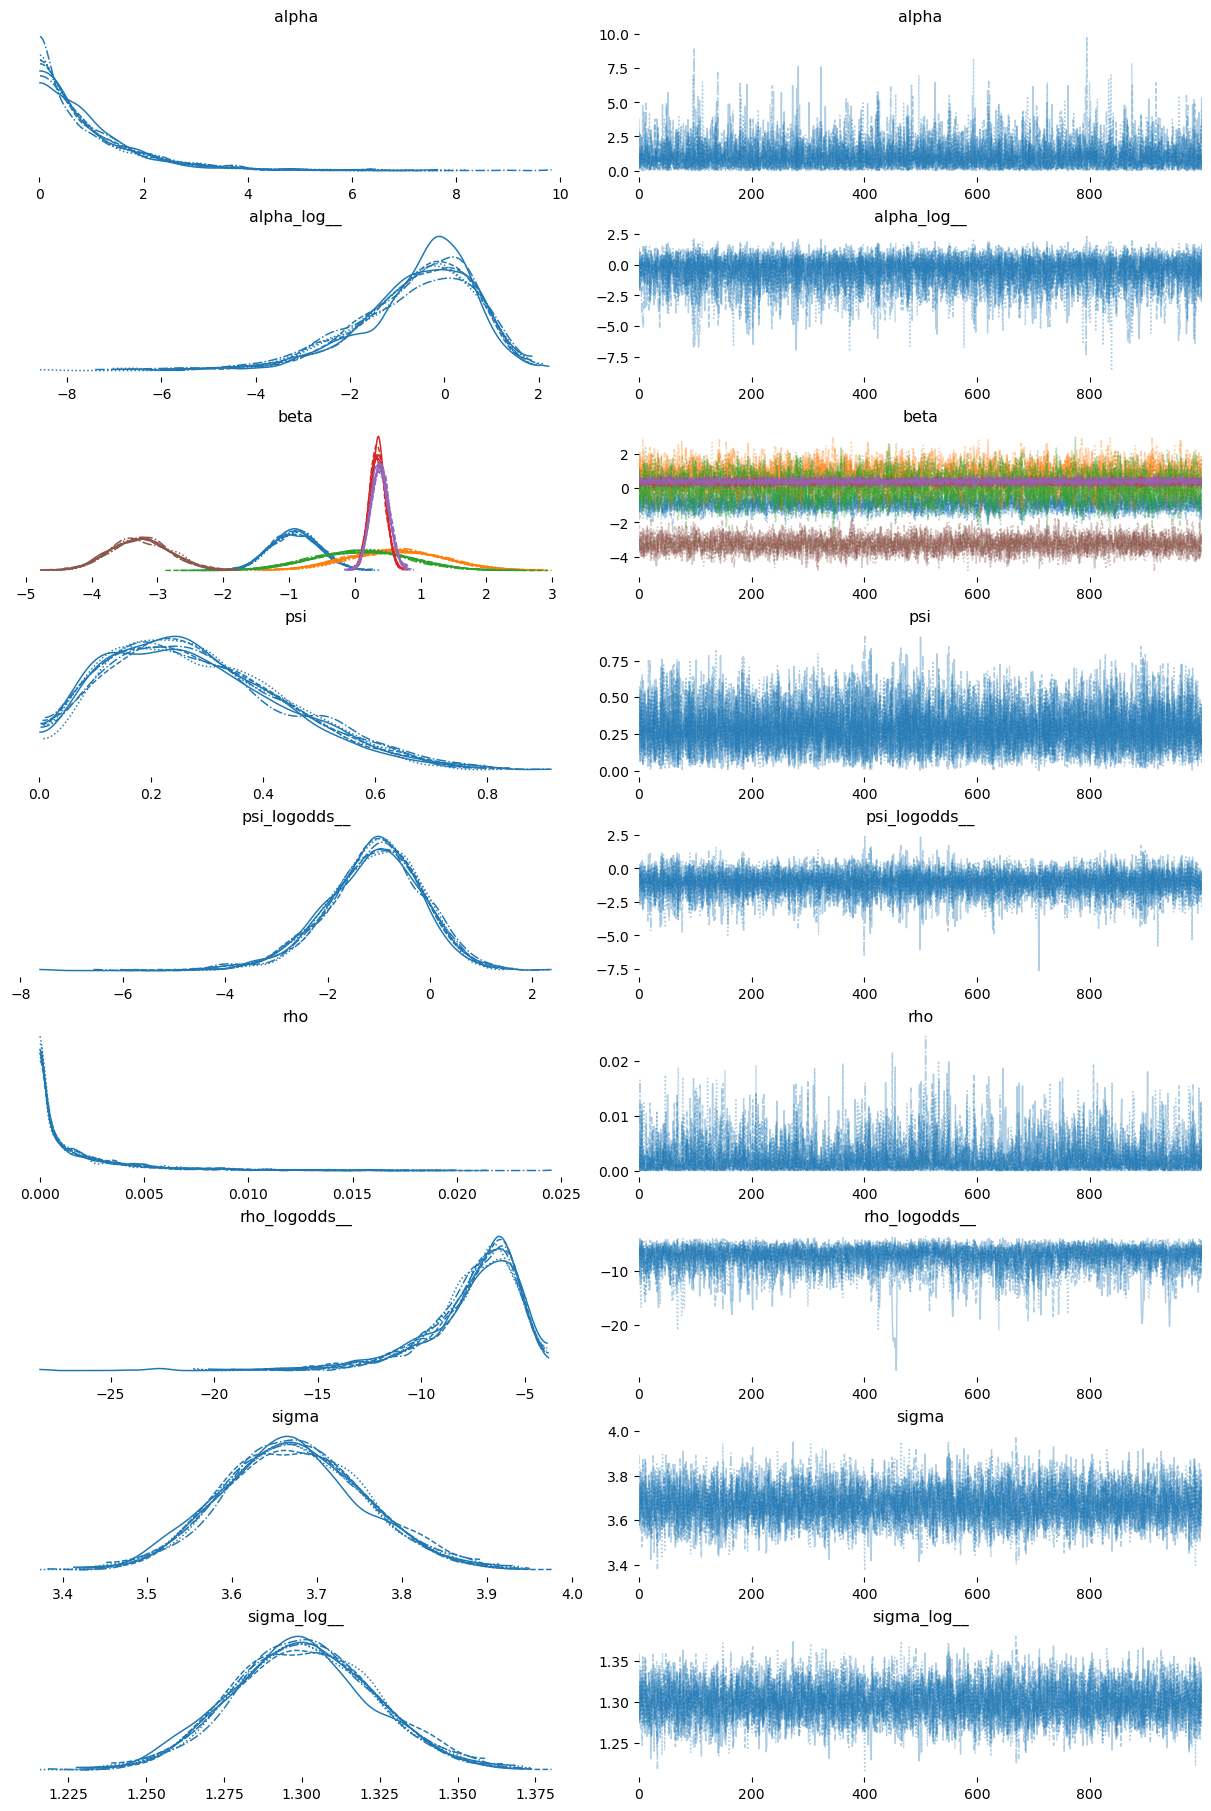

In [40]:
az.plot_trace(version_0_model_HydroMeteorological_idata, var_names =  ["~country_effect", "~theta", "~phi", "~mixture", "~mu"]);

### PPC

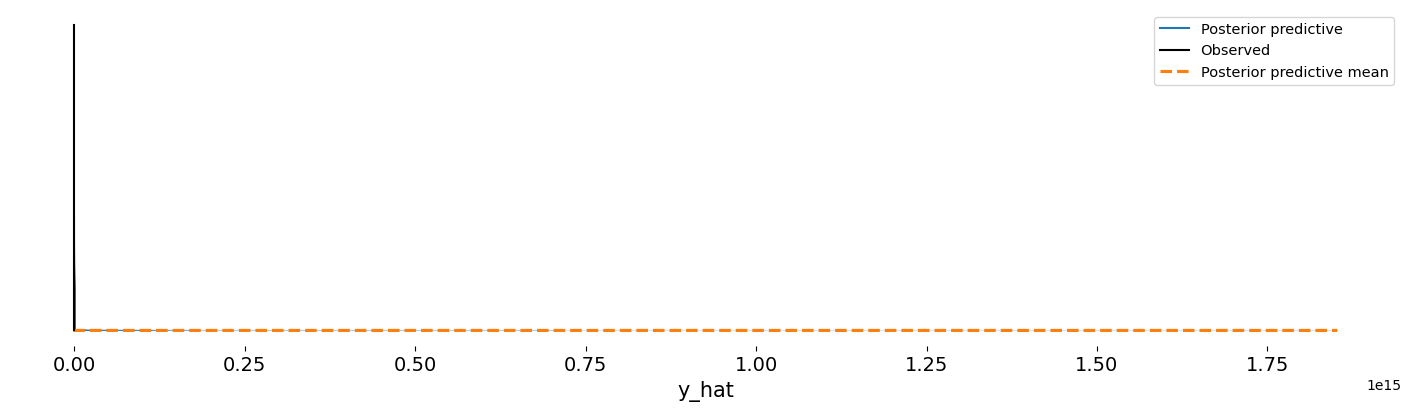

In [41]:
az.plot_ppc(version_0_model_HydroMeteorological_idata);

### Posterior

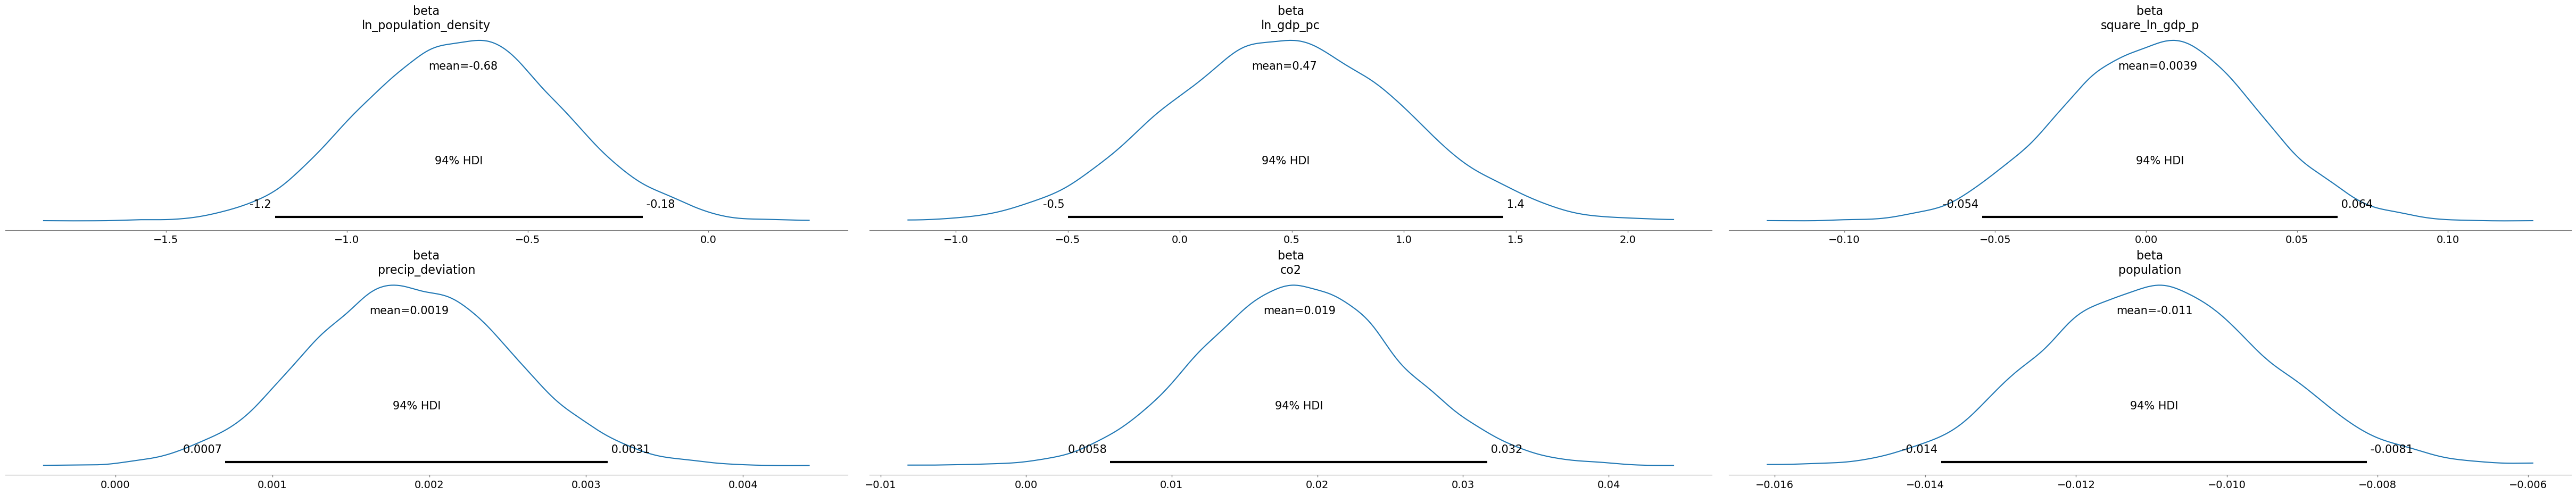

In [42]:
#To de-normalize the parameters
az.plot_posterior((version_0_model_HydroMeteorological_idata.posterior.beta / standard_deviations[features_0H].values).astype(float) , 
                  var_names=["beta"]);

###  inverse cdf uniform transform plot

C:\Users\camil\AppData\Local\Temp\ipykernel_46464\1294632583.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


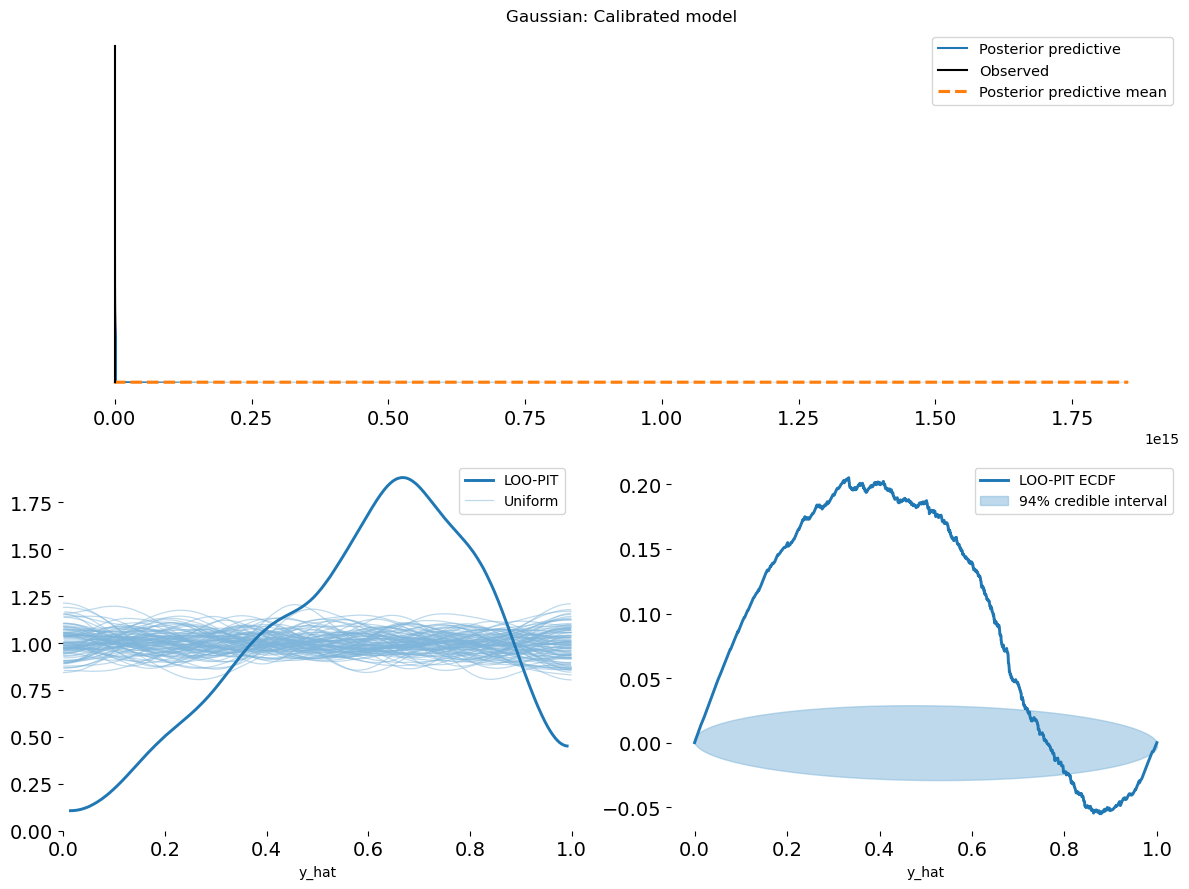

In [43]:
plot_ppc_loopit(version_0_model_HydroMeteorological_idata, "Gaussian: Calibrated model")
plt.tight_layout();

### Predictions

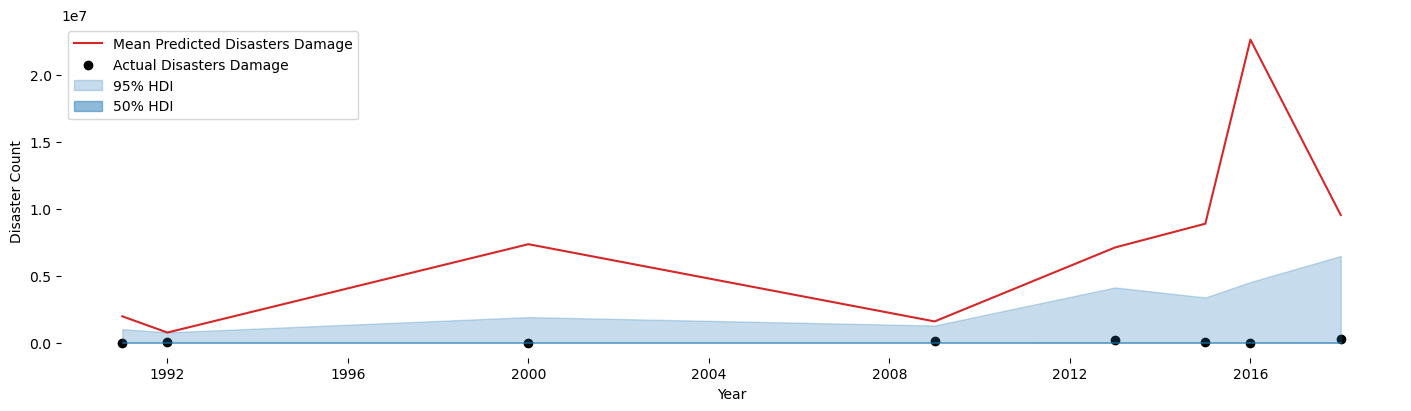

In [44]:
plotting_function(idata = version_0_model_HydroMeteorological_idata,
                  disaster_type = "hydrometereological",
                  country= "LAO")

# version_0_model_Climatological: no dev_from_trend_ocean_temp

## Reconcile EMDAT and shapefile ISO codes

In [45]:
#Load shapefiles
world = load_shapefile('world', repair_ISO_codes=True)
world.set_index('ISO_A3', inplace=True)

In [46]:
df_iso = df_climatological["ISO"].unique()
world_iso = world.index.unique()

In [47]:
# Codes in EMDAT but not in world
# These are all historical:
", ".join(list(set(df_iso) - set(world_iso)))

''

In [48]:
# Codes in shapefile but not in EMDAT
", ".join(list(set(world_iso) - set(df_iso)))

'ISR, QAT, MHL, COM, GUM, MNE, SLE, IMN, JOR, LUX, SLB, CUW, GIN, BMU, SPM, WLF, VCT, PRK, SYC, HKG, UNK, LVA, VAT, GAB, FRO, COK, GRL, MNP, LSO, TGO, SUR, PSE, BTN, MCO, CYP, SSD, SXM, TUV, KNA, GIB, FIN, FSM, GMB, ATF, CPV, KIR, DMA, VIR, SYR, KWT, NCL, SHN, MLI, PCN, NIU, GRD, GNQ, TKM, SGP, DNK, GNB, AND, BRB, SGS, BEL, HMD, LIE, MDV, CIV, IOT, ABW, CYM, LCA, MSR, TCA, FLK, TON, JEY, ASM, BHR, TTO, ISL, SMR, STP, MAC, VEN, PRI, BLM, AIA, EST, JAM, BRN, SWE, MAF, NRU, NFK, GGY, BHS, ATG, DJI, VGB, MLT, PLW, ARE'

In [49]:
# Drop codes not in both
common_codes = set(world_iso).intersection(set(df_iso))
df_climatological = df_climatological.set_index(["ISO", "year"]).loc[lambda x: x.index.get_level_values(0).isin(common_codes)].copy()

world = world.loc[world.index.isin(common_codes)].copy()

df_climatological = df_climatological.reset_index()

In [50]:
# Get unique iso codes and years
code_idx, codes = pd.factorize(df_climatological["ISO"], sort=True)
year_idx, years = pd.factorize(df_climatological["year"], sort=True)

disasters = ["climatological_disasters", "hydrological_disasters"]

## Nodes and adjacency matrix

In [51]:
with warnings.catch_warnings(action='ignore'):
    # Make graph of bordering countires
    w1 = fuzzy_contiguity(world)
    
    # Robustness of statistics to choice of k?
    w2 = KNN.from_dataframe(world, k=2)    
    w = w_union(w1, w2)
    keys = sorted(list(w.neighbors.keys()))
    
    G = w.to_networkx().to_undirected()
    
    # Discard all but the main connected component (largest connected subgraph)
    G = nx.subgraph(G, list(nx.connected_components(G))[0])
    
    # Make a dataset of only the regions in the resulting graph
    connected_world = world.iloc[list(G.nodes)].copy()
    idx_to_name = dict(enumerate(keys))
    
    # Change node names from numbers to ISO codes and do a sanity check
    G = nx.relabel_nodes(G, idx_to_name)
    #assert list(G['USA'].keys()) == ['CAN', 'MEX']
    
    
    # Compute the weight matrix resulting from the graph and do a sanity check
    w = W.from_networkx(G)
    w.remap_ids(list(G.nodes))
    #assert w.neighbors['USA'] == ['CAN', 'MEX']

In [52]:
# Adjusting the shapes of coords and data
not_in_connected_world = []

for country in (df_hydrometereological["ISO"].unique()):
    if country not in connected_world.index.values :
        not_in_connected_world.append(country)

In [53]:
df_climatological = df_climatological.set_index(['ISO'])
df_climatological = df_climatological.drop(not_in_connected_world)
df_climatological = df_climatological.reset_index()

In [54]:
#Creating the adjacency matrix
A = nx.adjacency_matrix(G)

In [55]:
# Compute node positions for network graph (spring layout)
pos = nx.drawing.nx_pydot.graphviz_layout(G, 'neato')

In [56]:
#Defining the scaling factor
scaling_factor = scaling_factor_sp(A)
scaling_factor

1.0025148703042845

In [57]:
def network_plotting(y_predict, G =G):
    fig, ax = plt.subplots(figsize=(12, 8), dpi=77)
    node_paths = nx.draw_networkx_nodes(
        G,
        pos=pos,
        node_color= y_predict.sel(year = "2018-01-01").to_numpy(),
        cmap="plasma",
        alpha=0.6,
        vmax=40,
        node_size=30 + 70 * np.log(y_predict.sel(year = "2018-01-01").to_numpy()),
    )
    node_edges = nx.draw_networkx_edges(G, pos=pos, width=0.5)
    fig.colorbar(node_paths, shrink=0.75, extend='max')
    ax.axis('off');
    # plt.show()

## Define features and coords

In [58]:
#Define features and normalize variables
features_0C = ["ln_population_density", "ln_gdp_pc", "square_ln_gdp_p", "precip_deviation", "co2", "population"]

In [59]:
#Define features and normalize variables
df_climatological1 = df_climatological.drop(columns = "ISO")

df_climatological1_norm = (df_climatological1 -df_climatological1.mean())/ df_climatological1.std()

standard_deviations = df_climatological1.std()

C:\Users\camil\AppData\Local\Temp\ipykernel_46464\3687074068.py:4: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_climatological1_norm = (df_climatological1 -df_climatological1.mean())/ df_climatological1.std()


In [60]:
#Creating idx
idx = xr.Coordinates.from_pandas_multiindex(df_climatological.set_index(["ISO", "year"]).index , dim = "obs_idx")

#Creating results_dict
results_dict = {}

In [61]:
#Set coordinates
ISO_idx, ISO =  pd.factorize(df_climatological["ISO"])
obs_idx = df_climatological1.index.values

COORDS = {'ISO':ISO, 
          #'Year_vals':df['Start_Year'].cat.categories.values,
          "obs_idx": obs_idx,
         "feature": features_0C}

## model

In [62]:
#HydroMeteorological Disasters

with pm.Model(coords=COORDS) as version_0_model_Climatological:
    #Declare data
    X, Y= add_data(features= features_0C ,  target = "Total_Damage_Adjusted_clim" , df = df_climatological, df_norm= df_climatological1_norm)

    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [ 1, 1, 1, 1, 1, 1]
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])

    # independent random effect
    theta = pm.Normal("theta", mu = 0, sigma = 1, dims = ["ISO"])

    # spatially structured random effect
    phi = pm.ICAR("phi", W = A.todense(), dims = ["ISO"])

    # the mixing rate rho
    rho = pm.Beta("rho", 0.5, 0.5)

    # the bym component : mixes a spatial and a random effect
    mixture = pm.Deterministic("mixture", pt.sqrt(1 - rho[None]) * theta + pt.sqrt(rho[None] / scaling_factor) *  phi, dims = ["ISO"])

    # joint variance of random effects
    sigma = pm.HalfNormal("sigma", 1)

    #Model mu
    regression_effect =  X @ beta
    #mu = pm.math.exp(country_effect[ISO_idx] + regression_effect + sigma[None] * mixture[ISO_idx])
    mu = pm.Deterministic("mu", pm.math.exp(country_effect[ISO_idx] + regression_effect + sigma[None] * mixture[ISO_idx]) , dims = ["obs_idx"])

    y_hat = add_obs_distribution(mu = mu ,sigma =sigma,  Y =Y, dist = "LogNormal")

In [63]:
version_0_model_Climatological_idata = sampling_function(version_0_model_Climatological)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.05,511
,2000,0,0.05,511
,2000,0,0.05,511
,2000,0,0.05,511
,2000,0,0.05,511
,2000,0,0.05,511
,2000,0,0.05,511
,2000,0,0.05,511


Sampling: [y_hat]


Output()

Output()

### Summary

In [64]:
az.summary(version_0_model_Climatological_idata,["~country_effect", "~country_effect_offset", "~theta", 
                                                        "~phi", "~mixture", "~mu"])

C:\Users\camil\anaconda3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:142: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.006,0.990,0.000,2.859,0.011,0.008,5517.0,3277.0,1.0
alpha_log__,-0.557,1.256,-2.887,1.498,0.020,0.018,5517.0,3277.0,1.0
beta[ln_population_density],-0.146,0.088,-0.303,0.027,0.001,0.001,12888.0,6349.0,1.0
beta[ln_gdp_pc],0.220,0.180,-0.105,0.565,0.002,0.002,5900.0,5471.0,1.0
beta[square_ln_gdp_p],-0.174,0.195,-0.546,0.178,0.003,0.002,5826.0,5637.0,1.0
beta[precip_deviation],0.020,0.006,0.010,0.031,0.000,0.000,7985.0,4451.0,1.0
beta[co2],0.016,0.014,-0.011,0.044,0.000,0.000,10368.0,7094.0,1.0
beta[population],0.013,0.039,-0.059,0.088,0.000,0.000,9728.0,6987.0,1.0
psi,0.289,0.160,0.019,0.575,0.002,0.001,7290.0,3613.0,1.0
psi_logodds__,-1.062,0.925,-2.915,0.564,0.011,0.011,7290.0,3613.0,1.0


### Traces

C:\Users\camil\anaconda3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:142: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


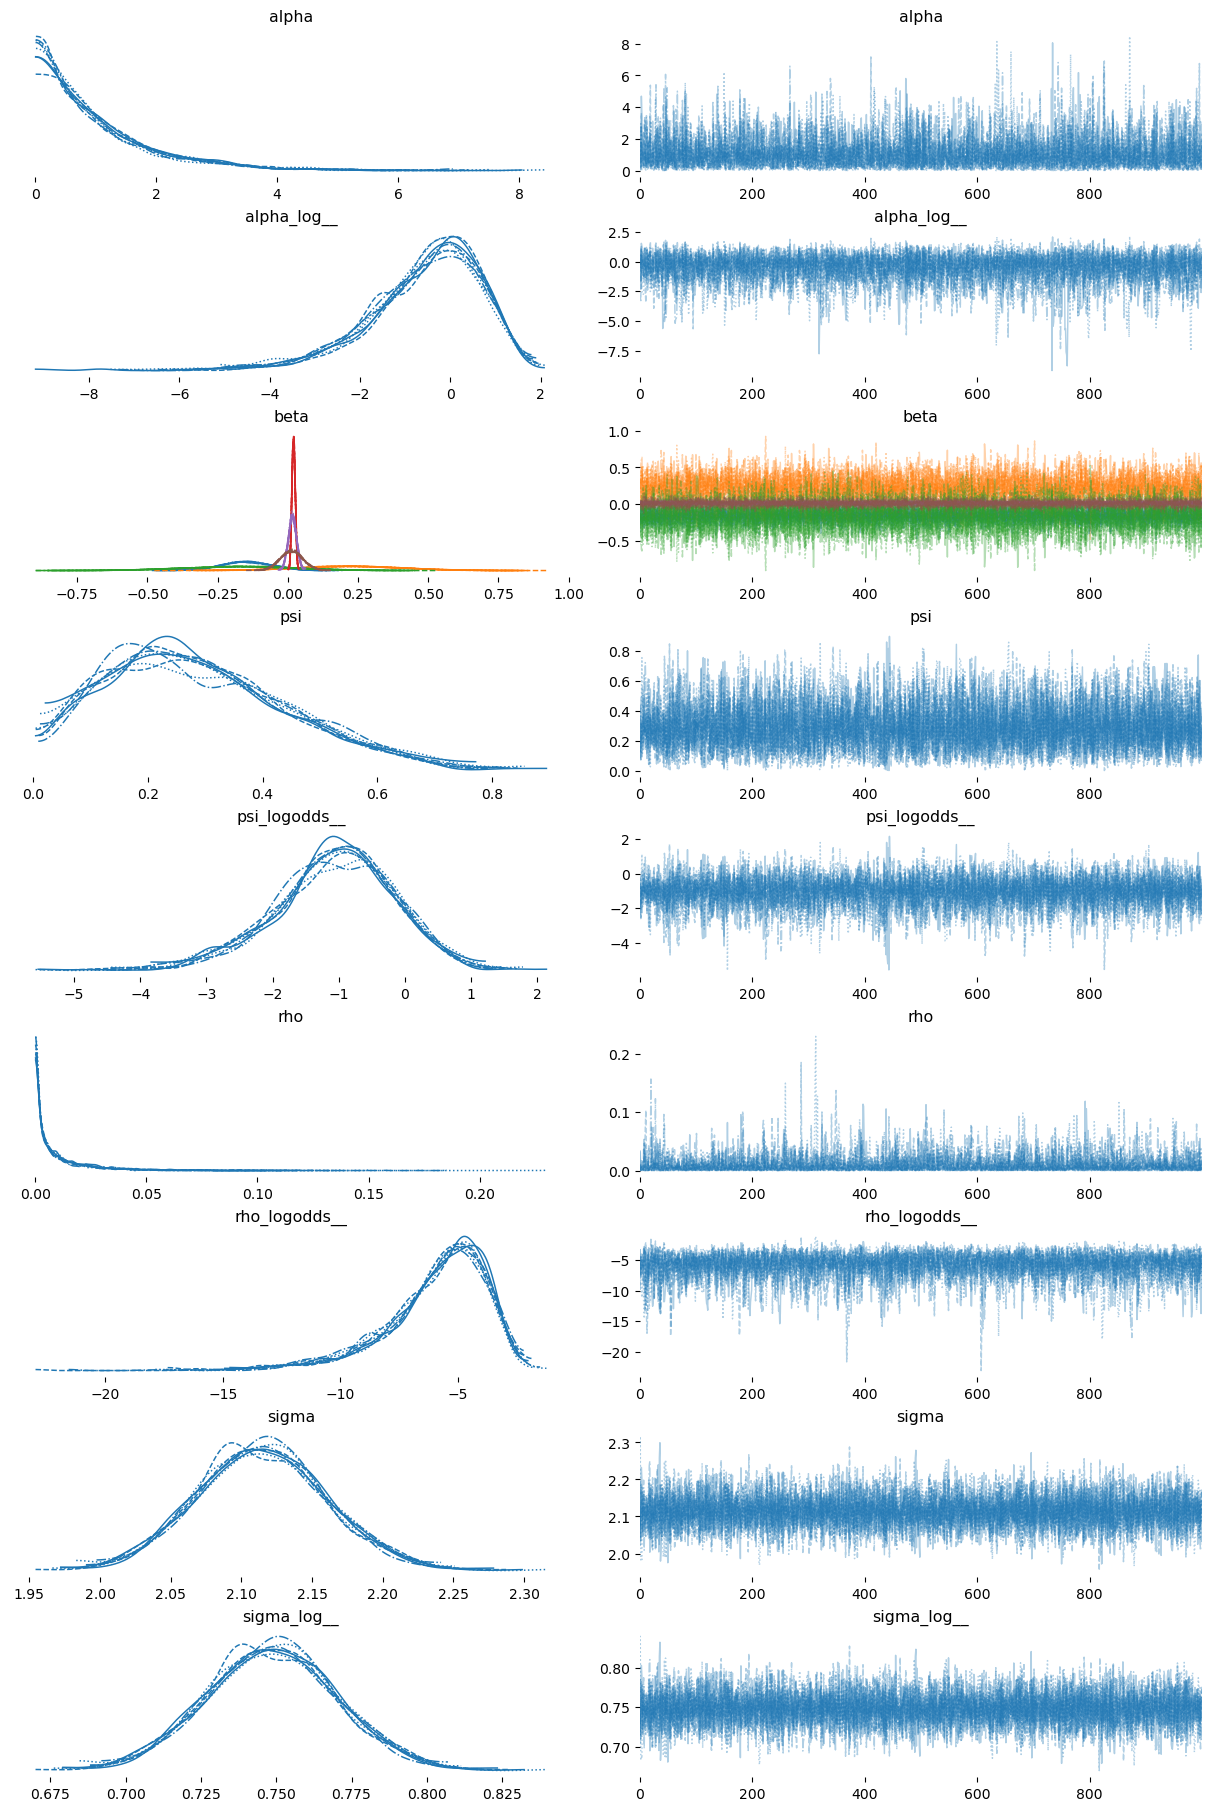

In [65]:
az.plot_trace(version_0_model_Climatological_idata, var_names = ["~country_effect", "~country_effect_offset", "~theta", 
                                                        "~phi", "~mixture", "~mu"]);

### PPC

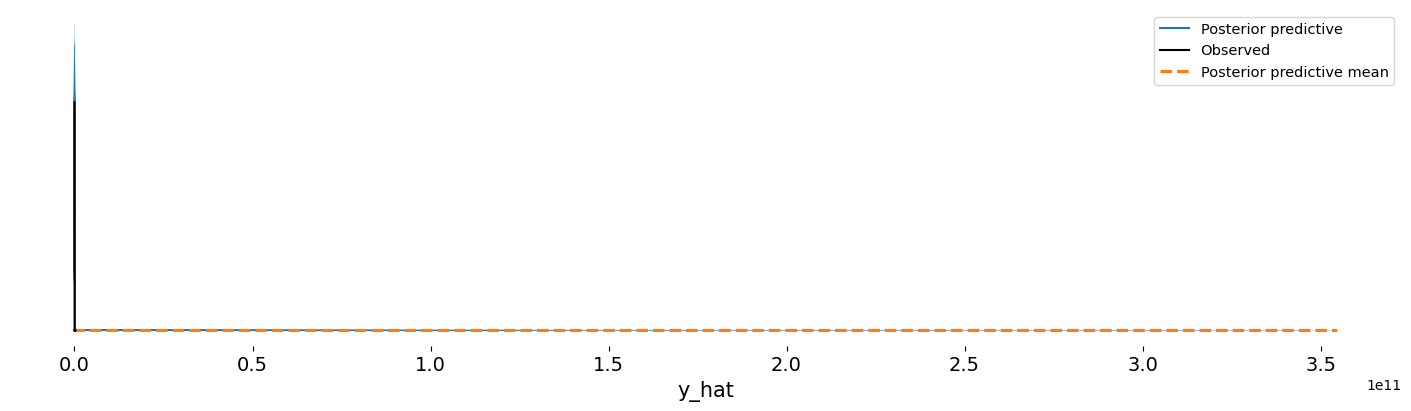

In [66]:
az.plot_ppc(version_0_model_Climatological_idata);

### Posterior

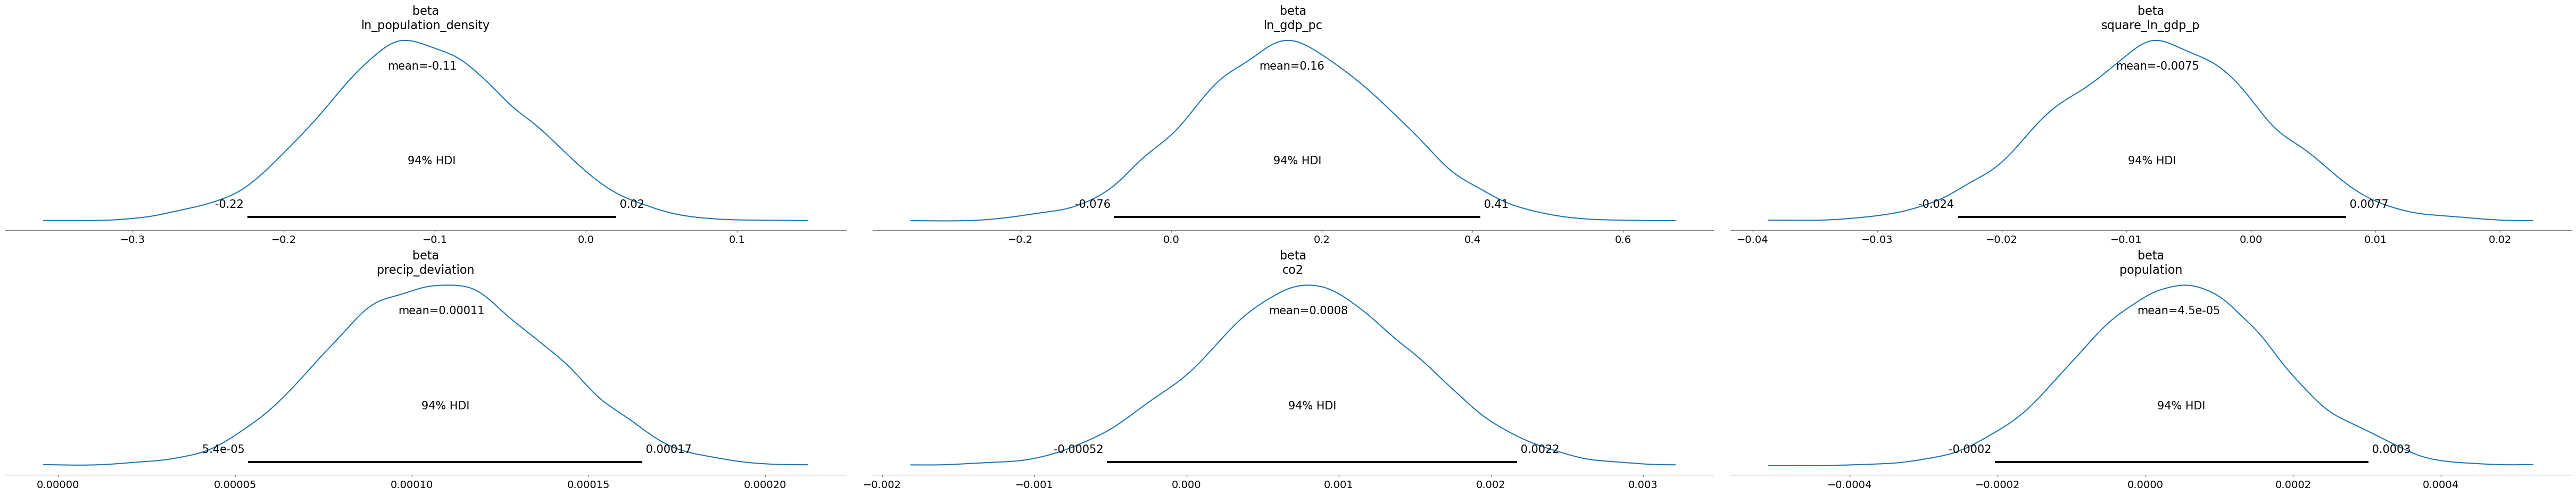

In [67]:
#To de-normalize the parameters
az.plot_posterior((version_0_model_Climatological_idata.posterior.beta / standard_deviations[features_0C].values).astype(float) ,
                  var_names=["beta"]);

###  inverse cdf uniform transform plot

C:\Users\camil\AppData\Local\Temp\ipykernel_46464\368484784.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


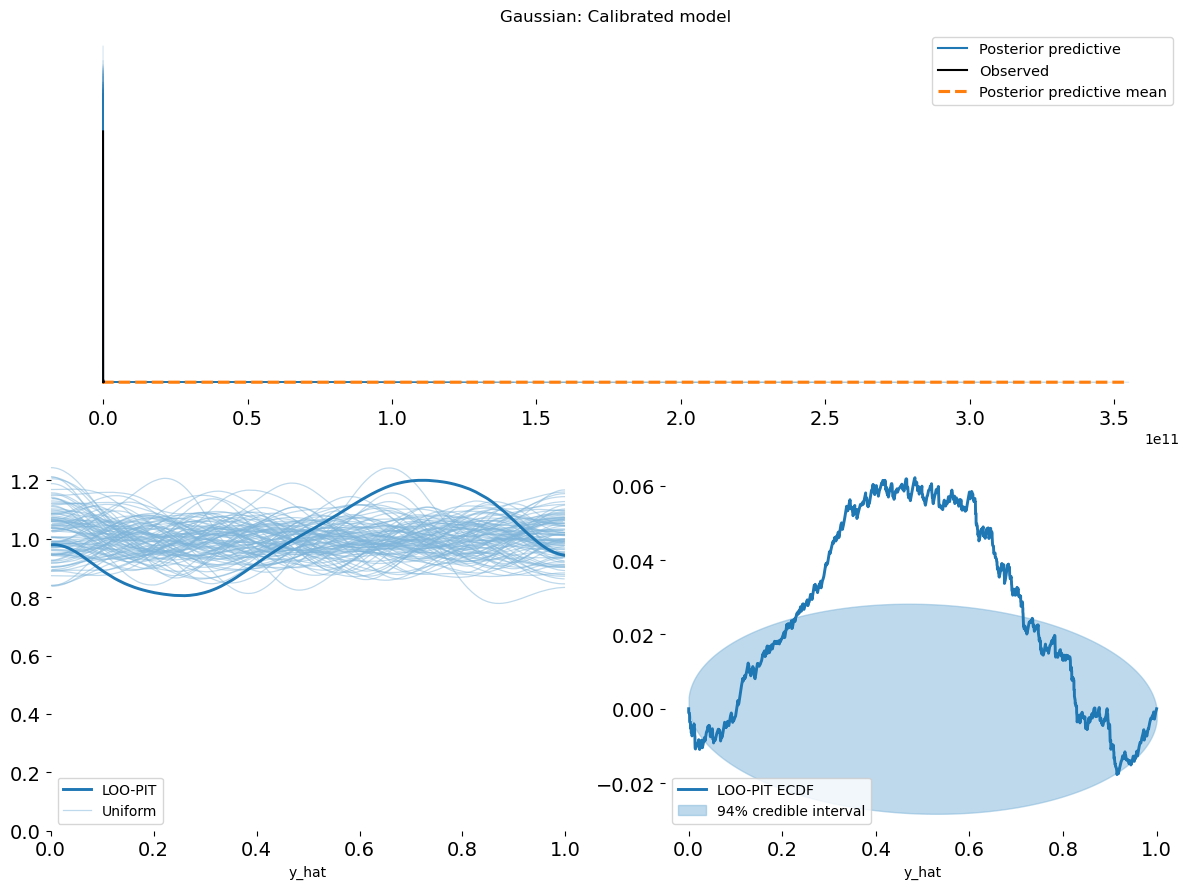

In [68]:
plot_ppc_loopit(version_0_model_Climatological_idata, "Gaussian: Calibrated model")
plt.tight_layout();

### Predictions

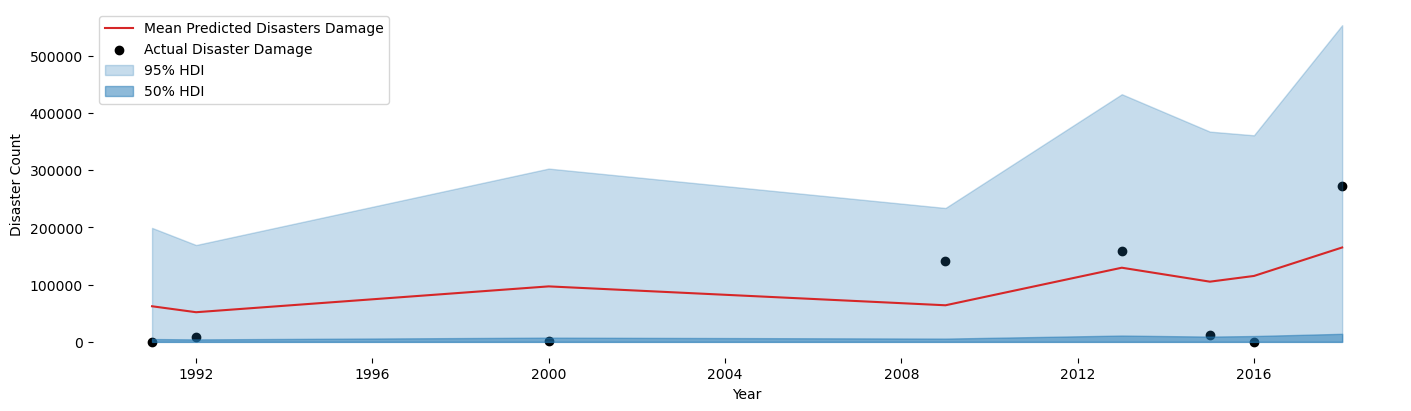

In [69]:
plotting_function(idata = version_0_model_Climatological_idata,
                  disaster_type = "climatological",
                  country= "LAO")